In [193]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imutils

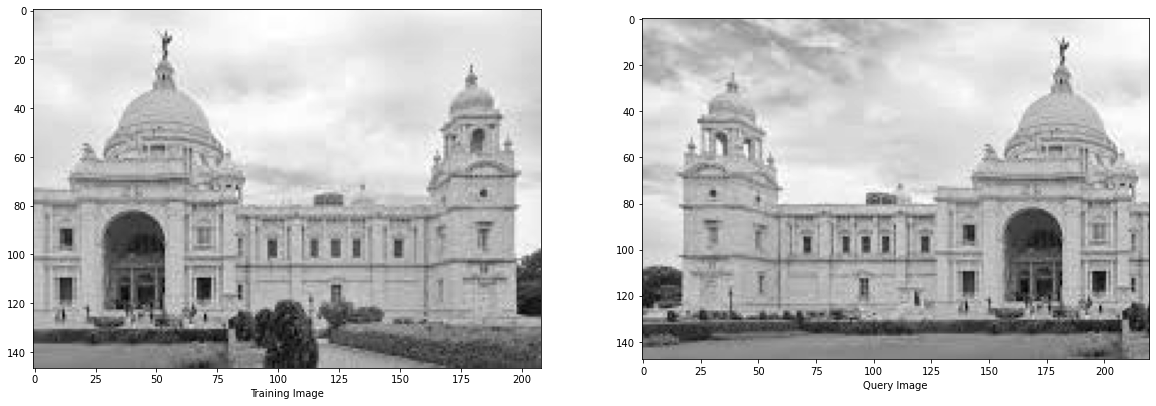

In [194]:
train_img_org = cv.imread('./Dataset/Pano_14.jpg')
query_img_org = cv.imread('./Dataset/Pano_13.jpg')

train_img = cv.cvtColor(train_img_org, cv.COLOR_BGR2GRAY)
query_img = cv.cvtColor(query_img_org, cv.COLOR_BGR2GRAY)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(train_img, cmap = 'gray')
ax1.set_xlabel('Training Image')

ax2.imshow(query_img, cmap = 'gray')
ax2.set_xlabel('Query Image')

cv.imshow('Train_Img', train_img)
cv.imshow('Query_Img', query_img)

cv.waitKey(0)
cv.destroyAllWindows()

In [195]:
# Creating descriptor
def descriptor_and_detect(image) :
    sift = cv.xfeatures2d.SIFT_create()

    # get keypoints and descriptors
    (kps, features) = sift.detectAndCompute(image, None)
    
    return kps, features

In [196]:
kps_train, features_train  = descriptor_and_detect(train_img)
kps_query, features_query  = descriptor_and_detect(query_img)

Text(0.5, 0, 'Fetaures of Query Image')

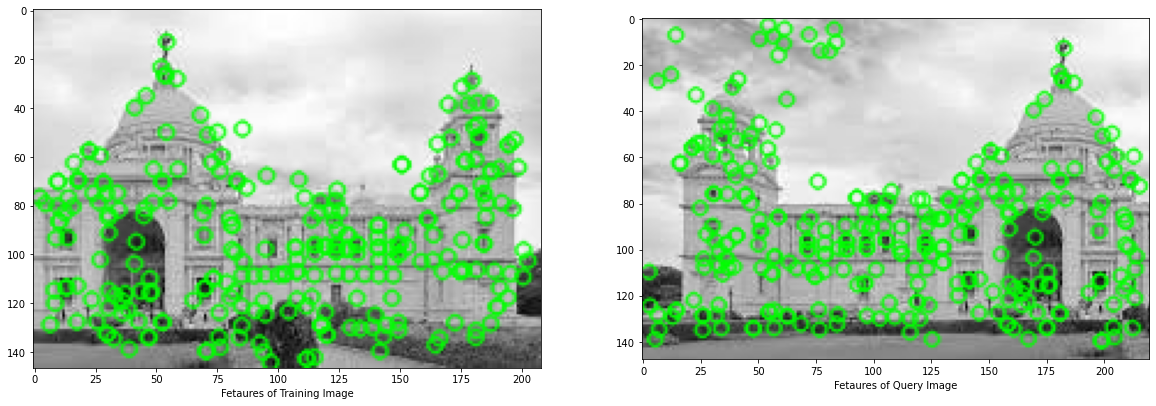

In [197]:
# Plotting the Features as described by SIFT detector
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.imshow(cv.drawKeypoints(train_img, kps_train, None, color = (0,255,0)))
ax1.set_xlabel('Fetaures of Training Image')

ax2.imshow(cv.drawKeypoints(query_img, kps_query, None, color = (0,255,0)))
ax2.set_xlabel('Fetaures of Query Image')

In [198]:
# creating the Matcher
def createMatcher(method, crossCheck) :
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck = crossCheck)
    return bf

In [199]:
# Finding the matching points between the Features of Training Image and Query Image using KNN
def matchKeyPointsKNN(featuresA, featuresB, ratio, method) :
    bf = createMatcher(method, crossCheck = False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Raw matches (knn): 269


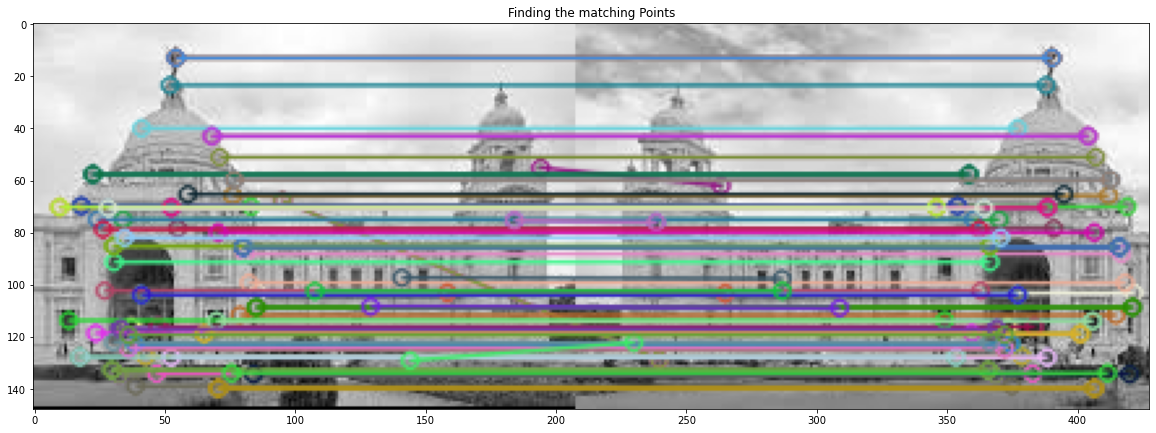

In [200]:
fig = plt.figure(figsize=(20,8))

matches = matchKeyPointsKNN(features_train, features_query, ratio=0.75, method = 'sift')
img3 = cv.drawMatches(train_img, kps_train, query_img, kps_query, np.random.choice(matches,100),
                           None,flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.title('Finding the matching Points')
plt.show()

In [201]:
# Finding the Transformation matrix(Homography matrix) to stitch the images
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv.findHomography(ptsA, ptsB, cv.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [202]:
M = getHomography(kps_train, kps_query, features_train, features_query, matches, reprojThresh=4)

if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.97841610e-01 -4.22046064e-04  1.28046244e+02]
 [-8.91231803e-04  9.99222742e-01  6.38763111e-02]
 [-7.80967309e-06 -1.75964221e-06  1.00000000e+00]]


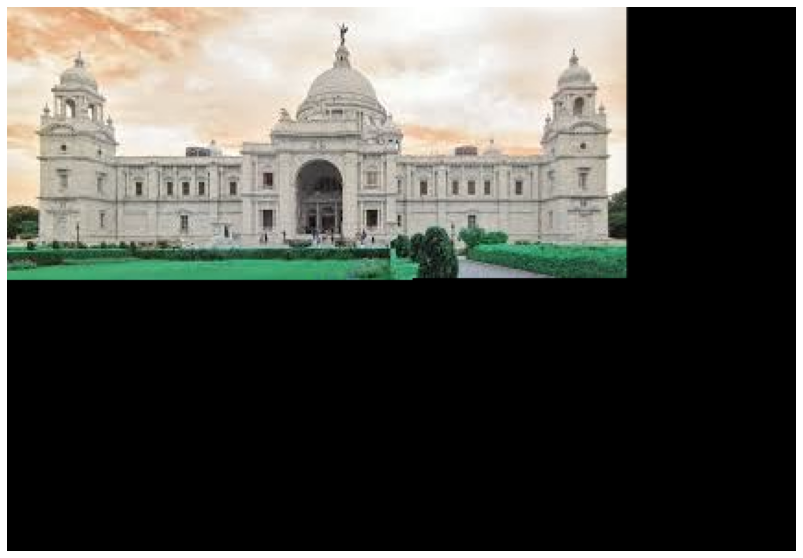

In [203]:
# Apply panorama correction
width = train_img.shape[1] + query_img.shape[1]
height = train_img.shape[0] + query_img.shape[0]

result = cv.warpPerspective(train_img_org, H, (width, height))
result[0:query_img_org.shape[0], 0:query_img_org.shape[1]] = query_img_org

plt.figure(figsize=(20,10))
plt.imshow(result)

# cv.imshow('Result', result)

plt.axis('off')
plt.show()
cv.waitKey(0)
cv.destroyAllWindows()

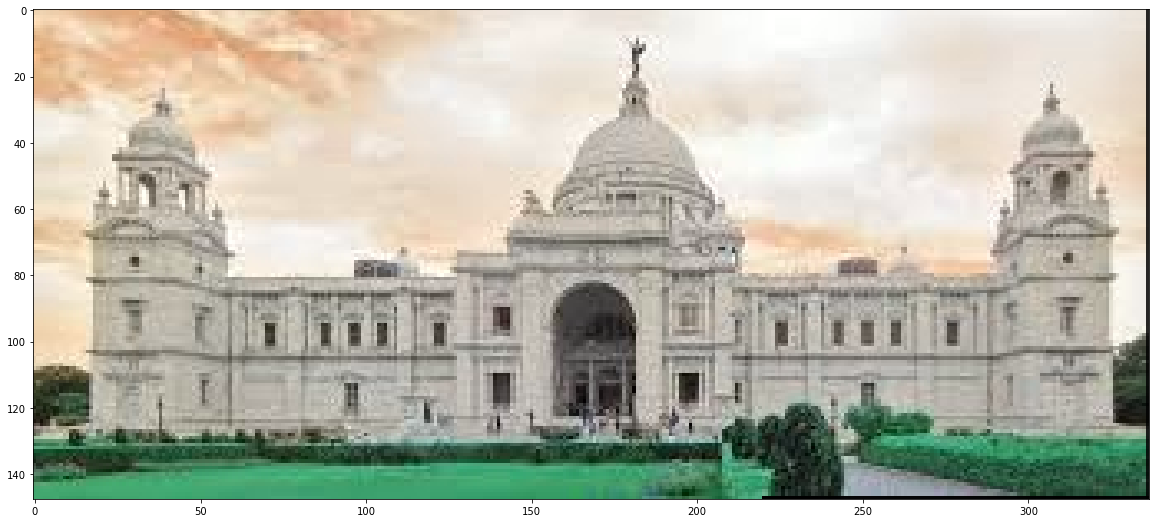

In [204]:
# transform the panorama image to grayscale and threshold it 
gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

cv.imshow('Final Stitched Image', result)
cv.waitKey(0)
cv.destroyAllWindows()